<a href="https://colab.research.google.com/github/karmanandan/karma_nandan.github.io/blob/master/95_accuracy_with_xception_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Activation, Dense, Flatten
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import classification_report

In [ ]:
os.listdir('../input/100-bird-species')

['class_dict.csv',
 'EfficientNetB3-birds-98.40.h5',
 'valid',
 'test',
 'birds.csv',
 'images to test',
 'train']

In [ ]:
parent_dir = '../input/100-bird-species'
train_dir = os.path.join(parent_dir, 'train')
test_dir = os.path.join(parent_dir, 'test')
valid_dir = os.path.join(parent_dir, 'valid')

In [ ]:
train_dirs = os.listdir(train_dir)
print(f'Folder count in train_dirs - {len(train_dirs)}')
print('*'*50)
test_dirs = os.listdir(test_dir)
print(f'Folder count in test_dirs - {len(test_dirs)}')
print('*'*50)
valid_dirs = os.listdir(valid_dir)
print(f'Folder count in valid_dirs - {len(valid_dirs)}')

Folder count in train_dirs - 325
**************************************************
Folder count in test_dirs - 325
**************************************************
Folder count in valid_dirs - 325


In [ ]:
image_path = []
label = []

def imagesLabels(dirs,dir_):
    for di in dirs:
        for path in os.listdir(dir_+'/'+di):
            image_path.append(dir_+'/'+di+'/'+path)
            label.append(di)
    return image_path, label

In [ ]:
# train
train_Im, train_Lb = imagesLabels(train_dirs,train_dir)
# test
test_Im, test_Lb = imagesLabels(test_dirs,test_dir)
# validation
val_Im, val_Lb = imagesLabels(valid_dirs,valid_dir)

In [ ]:
train_df = pd.DataFrame([train_Im, train_Lb])
new_df = train_df.T

In [ ]:
new_df.columns = ['ImageDir','ImageLable']

In [ ]:
test_df = pd.DataFrame([test_Im, test_Lb])
new_test_df = test_df.T
new_test_df.columns = ['ImageDir','ImageLable']

In [ ]:
valid_df = pd.DataFrame([val_Im, val_Lb])
new_valid_df = valid_df.T
new_valid_df.columns = ['ImageDir','ImageLable']

In [ ]:
# verify with sample data
new_df.sample(5)

,ImageDir,ImageLable
31723,../input/100-bird-species/train/GREEN JAY/022.jpg,GREEN JAY
36875,../input/100-bird-species/train/WILSONS BIRD O...,WILSONS BIRD OF PARADISE
44053,../input/100-bird-species/train/SPANGLED COTIN...,SPANGLED COTINGA
23795,../input/100-bird-species/train/EURASIAN GOLDE...,EURASIAN GOLDEN ORIOLE
48052,../input/100-bird-species/test/CHESTNET BELLIE...,CHESTNET BELLIED EUPHONIA


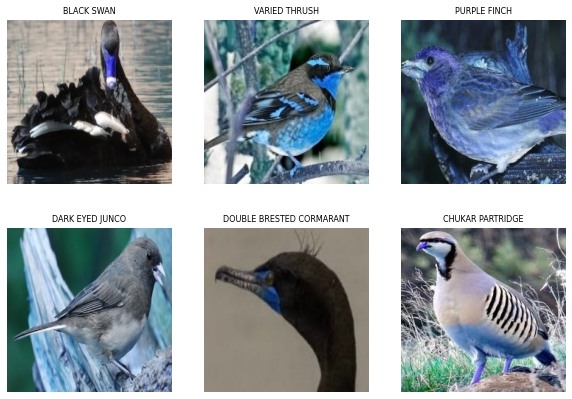

In [ ]:
# plotiing Images in Grid
plt.figure(figsize=(10,7))
for i,val in enumerate(list(np.random.randint(0,47332, size=(6)))): # total uimages count is 47332
    X = cv2.imread(new_df['ImageDir'][val])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(new_df['ImageLable'][val], fontsize=8)
    plt.imshow(X)
plt.show()

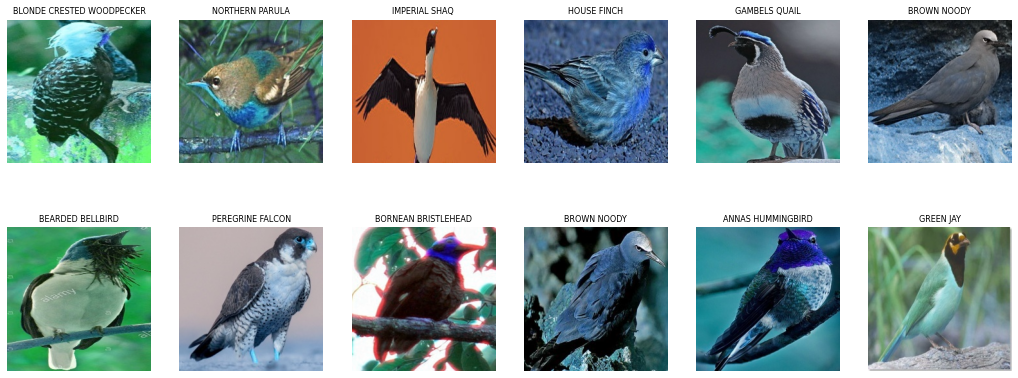

In [ ]:
plt.figure(figsize=(18,7))
for i,val in enumerate(list(np.random.randint(0,47332, size=(12)))):
    X = cv2.imread(new_df['ImageDir'][val])
    plt.subplot(2,6,+1 + i)
    plt.axis(False)
    plt.title(new_df['ImageLable'][val], fontsize=8)
    plt.imshow(X)
plt.show()

In [ ]:
# find image shape
im = load_img(new_df['ImageDir'][6782])
IMAGE_SHAPE = img_to_array(im).shape
IMAGE_SHAPE

(224, 224, 3)

In [ ]:
lable_count = Counter(new_df['ImageLable'])

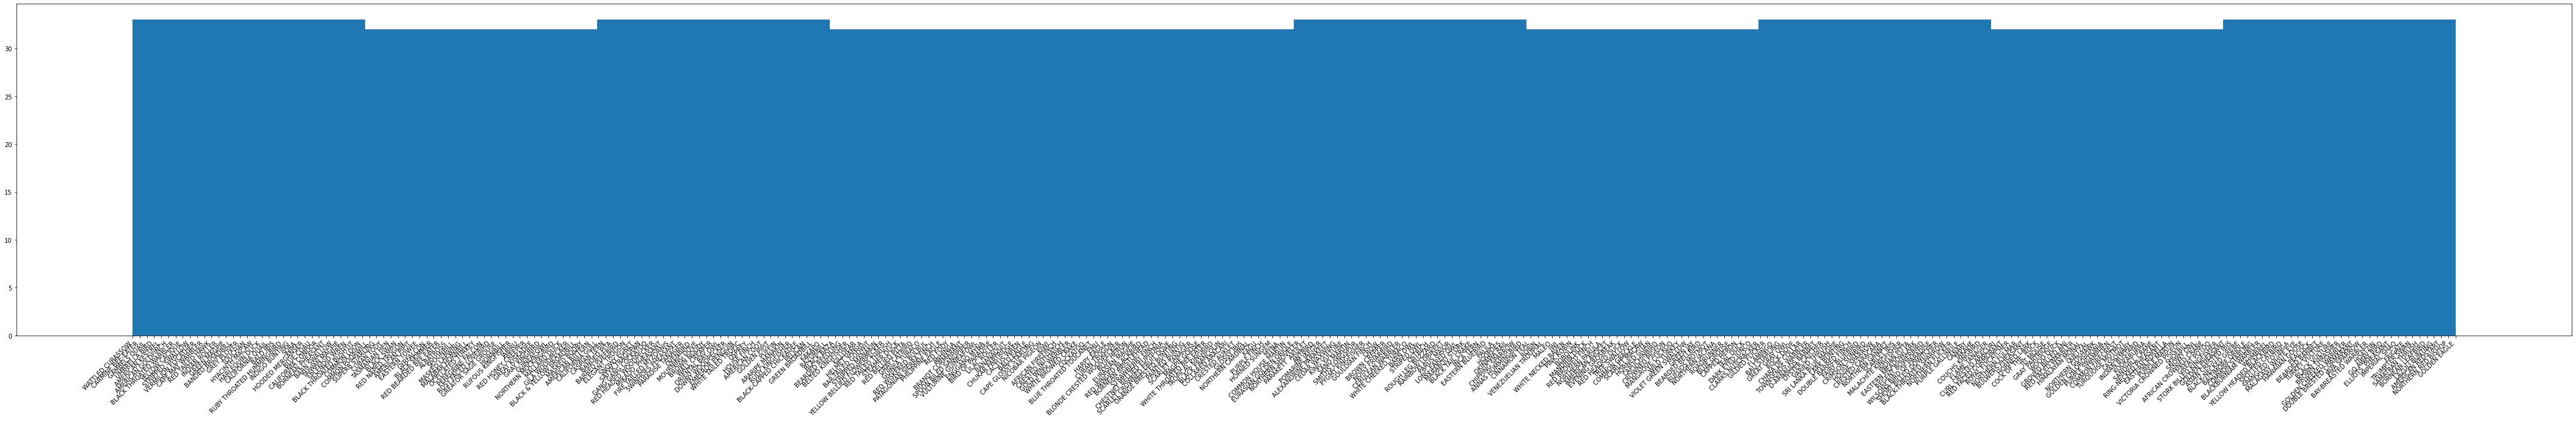

In [ ]:
plt.figure(figsize=(75,10))
plt.hist(lable_count)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
count_df = pd.DataFrame(new_df['ImageLable'].value_counts())
count_df

,ImageLable
HOUSE FINCH,259
OVENBIRD,243
D-ARNAUDS BARBET,243
SWINHOES PHEASANT,227
WOOD DUCK,224
...,...
GOLDEN PIPIT,130
BLACK SWAN,129
INCA TERN,129
CASSOWARY,129


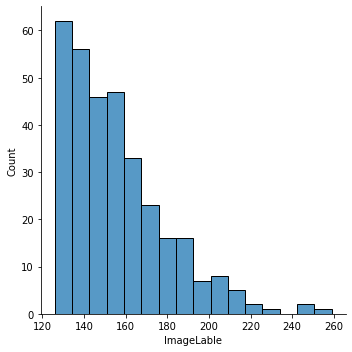

In [ ]:
sns.displot(count_df['ImageLable']);

In [ ]:
# CONVERING Categoricals to Numericals
new_df['ImageLable'] = new_df['ImageLable'].astype('category').cat.codes
new_valid_df['ImageLable'] = new_valid_df['ImageLable'].astype('category').cat.codes
new_test_df['ImageLable'] = new_test_df['ImageLable'].astype('category').cat.codes

In [ ]:
y_cat_train = to_categorical(new_df['ImageLable'])
y_cat_valid = to_categorical(new_valid_df['ImageLable'])
y_cat_test = to_categorical(new_test_df['ImageLable'])

In [ ]:
# Adding Simple Data Generator
DataGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 32
                                                                     )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode = "categorical",
                                                                    image_size = (224,224),
                                                                    batch_size = 32
                                                                    )
val_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                   label_mode= "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   )

Found 47332 files belonging to 325 classes.


2021-12-27 13:09:10.451707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 13:09:10.564529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 13:09:10.565586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 13:09:10.568536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 1625 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.


In [ ]:
train_generator = DataGenerator.flow_from_directory(train_dir,target_size=(224, 224))
valid_generator = DataGenerator.flow_from_directory(valid_dir,target_size=(224, 224))
test_generator = DataGenerator.flow_from_directory(test_dir,target_size=(224, 224))

Found 47332 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.


In [ ]:
# Xception Network

In [ ]:
class_count = 325

In [ ]:
xception_model = Xception(weights = 'imagenet', include_top = False, input_shape = IMAGE_SHAPE)
xception_model.trainable = False # Freeze the Xception weights.

model = Sequential()
model.add(xception_model)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(class_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = 'adam',# tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
history = model.fit( 
    train_generator,
    epochs = 20,
    validation_data = valid_generator,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
activation (Activation)      (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 325)               32614725  
_________________________________________________________________
activation_1 (Activation)    (None, 325)               0         
Total params: 53,476,205
Trainable params: 32,614,725
Non-trainable params: 20,861,480
_________________________________________________________________


2021-12-27 13:09:22.376804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-27 13:09:26.348267: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1480/1480 [==============================] - 342s 225ms/step - loss: 15.2162 - accuracy: 0.6041 - val_loss: 9.0277 - val_accuracy: 0.7766
Epoch 2/20
1480/1480 [==============================] - 153s 103ms/step - loss: 7.4598 - accuracy: 0.8187 - val_loss: 7.7474 - val_accuracy: 0.8388
Epoch 3/20
1480/1480 [==============================] - 151s 102ms/step - loss: 5.5834 - accuracy: 0.8672 - val_loss: 7.6764 - val_accuracy: 0.8332
Epoch 4/20
1480/1480 [==============================] - 155s 105ms/step - loss: 4.2874 - accuracy: 0.9016 - val_loss: 7.5390 - val_accuracy: 0.8720
Epoch 5/20
1480/1480 [==============================] - 157s 106ms/step - loss: 3.7657 - accuracy: 0.9178 - val_loss: 8.0012 - val_accuracy: 0.8794
Epoch 6/20
1480/1480 [==============================] - 153s 104ms/step - loss: 3.2569 - accuracy: 0.9313 - val_loss: 7.9606 - val_accuracy: 0.8782

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 7/20
1480/1480 [===================

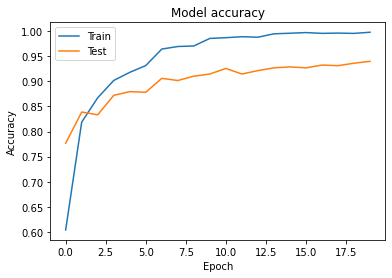

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

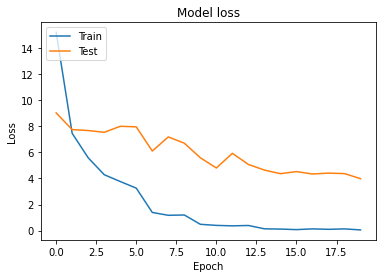

In [ ]:
# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Evaluate against test data.
scores = model.evaluate(test_generator, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

51/51 [==============================] - 12s 228ms/step - loss: 2.2864 - accuracy: 0.9514
Test loss: 2.286355972290039
Test accuracy: 0.9513846039772034


In [ ]:
test_labels = test_data.class_names

In [ ]:
# plt.figure(figsize=(16,16))

# for image, label in train_data.take(1):
#     model_prediction = model.predict(image)
#     for i in range(18):
#         plt.subplot(6,3,i+1)
#         plt.imshow(image[i].numpy().astype("uint8"))
#         plt.title(f"Model Prediction: {test_labels[tf.argmax(tf.round(model_prediction[i]))]}\n Original Labels : {test_labels[tf.argmax(label[i])]}")
#         plt.subplots_adjust(top=1.25)
#         plt.axis("off")
# plt.tight_layout()        
# plt.axis("off")